## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Бабаков Вадим Валерьевич

In [3]:
x = torch.rand(10)

In [4]:
net = nn.Sequential(nn.Linear(10,20), nn.ReLU(),
                    nn.Linear(20, 30), nn.ReLU())
#torch.save(net.state_dict(), "model.pt")
torch.save({"model_weights": net.state_dict(),
            "architecure_args": ...,
            "model_class" : ...})

y1 = net(x)

TypeError: save() missing 1 required positional argument: 'f'

In [5]:
new_n = nn.Sequential(nn.Linear(10,20), nn.ReLU(),
                    nn.Linear(20, 30), nn.ReLU())
new_n.load_state_dict(torch.load("model.pt"))
y2 = new_n(x)

In [10]:
y1-y2

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<SubBackward0>)

In [2]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [6]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [7]:
images_train, labels_train = next(iter(train_loader))

In [8]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

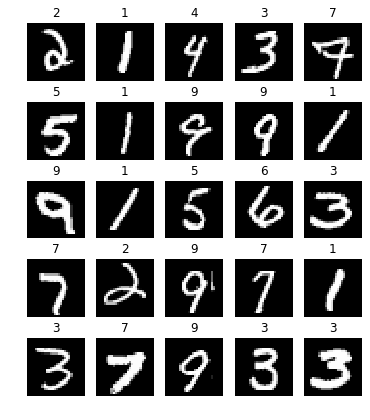

In [9]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [23]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)
    
def init_layer_uniform(layer, from_=0, to_=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(from_, to_)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [29]:
def new_linear_layer(input_size, output_size, activation_func=None, mean=0, std=1):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    if activation_func == None:
        init_layer(layer, 0, np.sqrt(2./(input_size + output_size)))
    elif activation_func == 'Xavier':
        init_layer_uniform(layer, -np.sqrt(6./(input_size + output_size)), np.sqrt(6./(input_size + output_size)))
    elif activation_func == 'He':
        init_layer(layer, 0, np.sqrt(2./(input_size)))
                           
    return layer

In [30]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): Tanh()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): Tanh()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): Tanh()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): Tanh()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): Tanh()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): Tanh()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): Tanh()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): Tanh()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): Tanh()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): Tanh()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): Tanh()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

In [31]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9819204211235046
forward 0.6373063921928406
forward 0.488461971282959
forward 0.41031238436698914
forward 0.36020755767822266
forward 0.32427817583084106
forward 0.29838448762893677
forward 0.27535030245780945
forward 0.2610263228416443
forward 0.2488512098789215
forward 0.23232705891132355
forward 0.2195730358362198
backward 0.025932911783456802
backward 0.0045065670274198055
backward 0.004514144267886877
backward 0.004245003219693899
backward 0.004053762648254633
backward 0.003926029894500971
backward 0.0034375565592199564
backward 0.003215615637600422
backward 0.0028761005960404873
backward 0.002641793107613921
backward 0.0019797016866505146
backward 0.001486088614910841


/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [35]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=mean, std=std, activation_func='He'))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=mean, std=std, activation_func='He'))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, mean=0, std=std, activation_func='He'))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9819204211235046
forward 0.7063524723052979
forward 0.6244574785232544
forward 0.5947214365005493
forward 0.574530839920044
forward 0.5563865900039673
forward 0.5584735870361328
forward 0.5576693415641785
forward 0.5578534603118896
forward 0.5601379871368408
forward 0.5561345815658569
forward 0.559537410736084
backward 0.030083926394581795
backward 0.0045201461762189865
backward 0.004766177851706743
backward 0.005018810275942087
backward 0.005245930980890989
backward 0.005855381488800049
backward 0.006435691379010677
backward 0.007170804776251316
backward 0.007177706807851791
backward 0.007397467270493507
backward 0.007712428458034992
backward 0.006675399374216795


/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [36]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=mean, std=std, activation_func='Xavier'))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=mean, std=std, activation_func='Xavier'))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, mean=0, std=std, activation_func='Xavier'))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9819204211235046
forward 0.6464412212371826
forward 0.49378669261932373
forward 0.4090349078178406
forward 0.3555169701576233
forward 0.3175821602344513
forward 0.29129117727279663
forward 0.27034425735473633
forward 0.25470390915870667
forward 0.2405553162097931
forward 0.22280104458332062
forward 0.21514813601970673
backward 0.027951447293162346
backward 0.0048196823336184025
backward 0.004583447705954313
backward 0.004086589906364679
backward 0.004022653680294752
backward 0.0038786581717431545
backward 0.003480214159935713
backward 0.0031837522983551025
backward 0.0029460610821843147
backward 0.0025856338907033205
backward 0.002187727252021432
backward 0.0016941229114308953


/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<i> 1.4 Сделайте выводы по первой части </i>

При инициализации He дисперсия активаций уменьшается слабее, чем при использовании приведённых аналогов. Дисперсия градиентов при инициализации He в среднем получается больше на коэффициент (меньше порядка)

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 9... (Train/Test) NLL: 0.026/0.080	Accuracy: 0.992/0.978

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


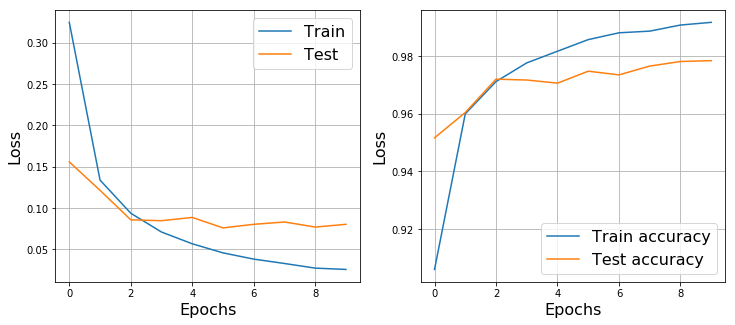

In [38]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 9... (Train/Test) NLL: 0.203/0.110	Accuracy: 0.939/0.968

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


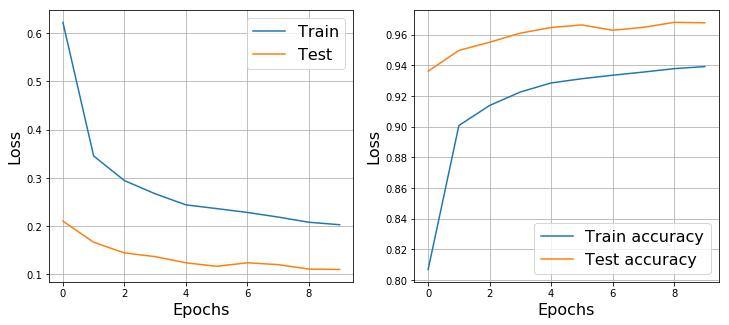

In [39]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

In [40]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+(1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 9... (Train/Test) NLL: 0.124/0.089	Accuracy: 0.961/0.972

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


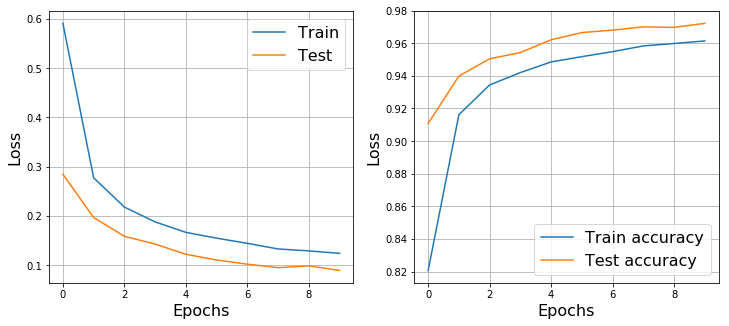

In [41]:
network = nn.Sequential(DropConnect(784, 100, p=0.5),
                        nn.ReLU(),
                        DropConnect(100, 100, p=0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 9... (Train/Test) NLL: 0.123/0.079	Accuracy: 0.963/0.977

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


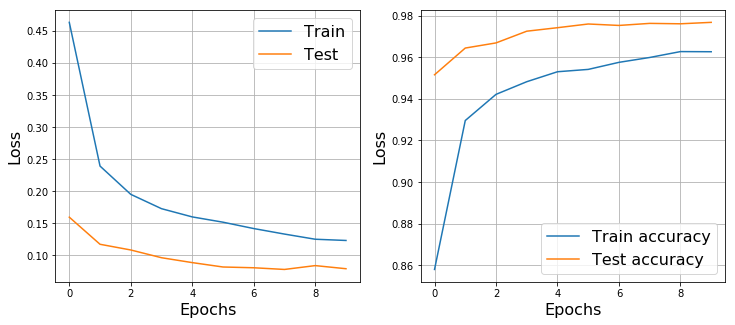

In [42]:
##### YOUR CODE HERE #####
network = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 9... (Train/Test) NLL: 0.079/0.078	Accuracy: 0.975/0.975

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


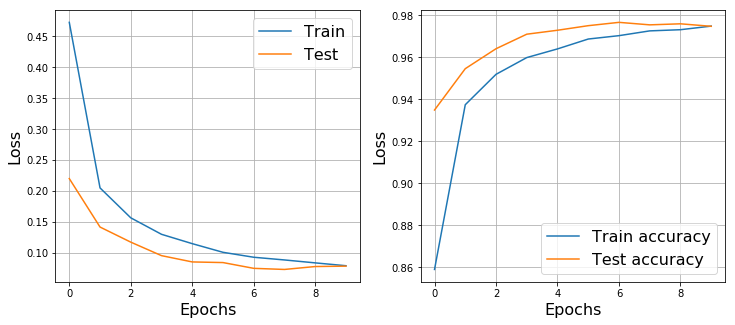

In [43]:
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по третьей части </i>

И Dropout, и DropConnect помогают бороться с переобучением, однако, по сравнению с конкретной сетью выше, на точность предсказания практически не влияют.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [56]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.FloatTensor(input_dim).fill_(1.0), requires_grad=True)
        self.delta = nn.Parameter(torch.FloatTensor(input_dim).fill_(0.01), requires_grad=True)
        
    def forward(self, x):
        output = self.gamma * (x - x.mean())/x.std() + self.delta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 19... (Train/Test) NLL: 0.006/0.085	Accuracy: 0.998/0.980

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


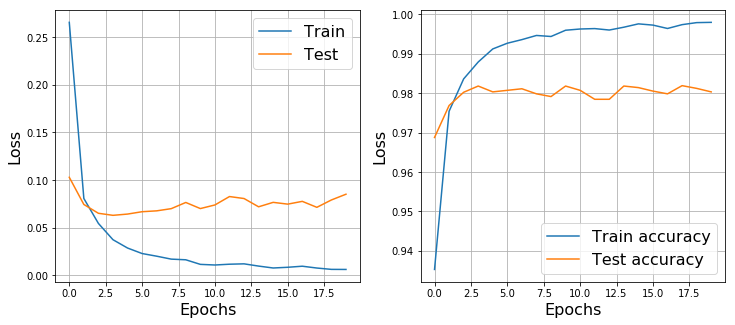

In [46]:
##### YOUR CODE HERE #####
network = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

/home/lepossum/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 19... (Train/Test) NLL: 0.006/0.088	Accuracy: 0.998/0.981

/home/lepossum/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


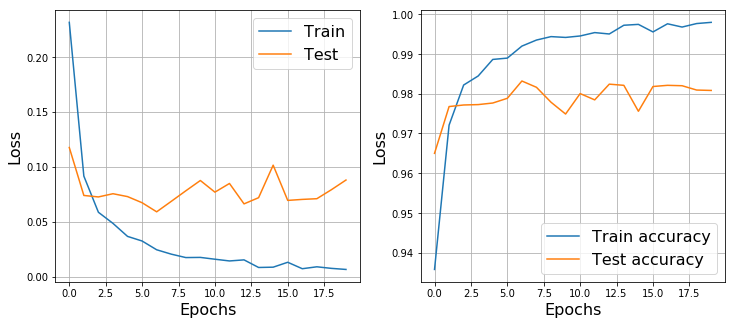

In [57]:
network = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 20, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

Графики обучения обеих сетей очень похожи: accuracy  на тестовой выборке на первой же итерации больше 0.9, но итоговая точность не самая впечатляющая, при этом сильно заметна проблема переобучения для обоих методов нормализации: accuracy на train-выборке сильно (всё относительно) выше, чем на тестовой.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: